In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import scipy
import seaborn
import sys
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import pickle
import scrublet as scr
import harmonypy as hm
from random import sample

### Load Data

In [2]:
#SC_DF = sc.read_h5ad('./DAP3_SC_072821.h5ad')

In [3]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "ALL_Large_sgRNA_Dic_Filtered.pkl", "rb")
SGRNA_CELLS_DIC = pickle.load(Dict_File)

In [4]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "Guide_Dictionary_Filtered.pkl", "rb")
Guide_Dictionary = pickle.load(Dict_File)

In [5]:
Clean_NC_Cells = []
[Clean_NC_Cells.extend(SGRNA_CELLS_DIC[i]) for i in Guide_Dictionary['NC']]

[None, None, None, None]

### Malat 1 Repression

In [6]:
Target_SG = []
Target_SG_Grouped = []

for cell in SC_DF.obs.index:
    if cell in SGRNA_CELLS_DIC['MALAT1']:
        Target_SG.append('sgMALAT1')
        Target_SG_Grouped.append('sgMALAT1')
    elif cell in Clean_NC_Cells:
        for NC in Guide_Dictionary['NC']:
            if cell in SGRNA_CELLS_DIC[NC]:
                Target_SG_Grouped.append('NC')
                Target_SG.append(NC)
    else:
        Target_SG.append('Other')
        Target_SG_Grouped.append('Other')

In [7]:
SC_DF_Group = SC_DF
SC_DF_Group.obs['SG'] = Target_SG_Grouped
SC_DF_Group_Subset = SC_DF_Group[SC_DF_Group.obs['SG'] != 'Other']


SC_DF.obs['SG'] = Target_SG
SC_DF_Subset = SC_DF[SC_DF.obs['SG'] != 'Other']

In [8]:
sc.tl.rank_genes_groups(SC_DF_Group_Subset, groupby = 'SG',method = 'wilcoxon')

Trying to set attribute `.obs` of view, copying.
... storing 'SG' as categorical


In [9]:
Gene = 'MALAT1'
Gene_Pos = np.argwhere(SC_DF_Group_Subset.raw.var_names == Gene)[0][0]
Target_Val = SC_DF_Group_Subset[SC_DF_Group_Subset.obs.SG == 'sgMALAT1'].raw.X[:, Gene_Pos].mean()/np.log(2)
NC_Val = SC_DF_Group_Subset[SC_DF_Group_Subset.obs.SG == 'NC'].raw.X[:, Gene_Pos].mean()/np.log(2)
print(str(100-(Target_Val/NC_Val*100)) + '% reduction in expression of MALAT1.')

28.1454630165143% reduction in expression of MALAT1.


In [10]:
Gene = 'MALAT1'
Gene_Pos = np.argwhere(SC_DF.raw.var_names == Gene)[0][0]
Perturbed_Cells = SC_DF[SC_DF.obs.SG == 'sgMALAT1']
NC1_Cells = SC_DF[SC_DF.obs.SG == 'NC:1']
NC2_Cells = SC_DF[SC_DF.obs.SG == 'NC:2']
NC3_Cells = SC_DF[SC_DF.obs.SG == 'NC:3']
NC4_Cells = SC_DF[SC_DF.obs.SG == 'NC:4']

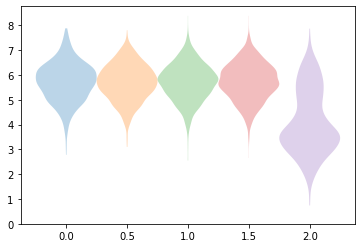

In [11]:
plt.violinplot(NC1_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[0], showextrema=False)
plt.violinplot(NC2_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[0.5], showextrema=False)
plt.violinplot(NC3_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[1], showextrema=False)
plt.violinplot(NC4_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[1.5], showextrema=False)
plt.violinplot(Perturbed_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[2], showextrema=False)


plt.ylim(0)
plt.savefig('./All_Violin_' + Gene + '.pdf')

### Statistics (MALAT1)

In [12]:
%%capture
CM_Control = SC_DF_Group_Subset[SC_DF_Group_Subset.obs.SG == 'NC']
Con_Mean = CM_Control.raw.X[:,Gene_Pos]/np.log(2)
Con_Means = []
[Con_Means.append(i[0]) for i in Con_Mean.mean(axis=1).tolist()]

CM_Perturb = SC_DF_Group_Subset[SC_DF_Group_Subset.obs.SG == 'sgMALAT1']
Perturb_Mean = CM_Perturb.raw.X[:,Gene_Pos]/np.log(2)
Perturb_Means = []
[Perturb_Means.append(i[0]) for i in Perturb_Mean.mean(axis=1).tolist()]



In [13]:
print('p-val = ' + str(scipy.stats.mannwhitneyu(Perturb_Means, Con_Means)[1]))

p-val = 0.0
